In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/international-football-results-from-1872-to-2017/shootouts.csv
/kaggle/input/international-football-results-from-1872-to-2017/results.csv
/kaggle/input/fifaworldranking/fifa_ranking-2021-05-27.csv
/kaggle/input/soccer/Olympic 2020 Dataset.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

rankings = pd.read_csv('../input/fifaworldranking/fifa_ranking-2021-05-27.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'rank_date']]
rankings = rankings.replace({"IR Iran": "Iran","Côte d'Ivoire" : "Ivory Coast"})
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('../input/international-football-results-from-1872-to-2017/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'South Korea': 'Korea Republic'})
matches['date'] = pd.to_datetime(matches['date'])

olympic = pd.read_csv('../input/soccer/Olympic 2020 Dataset.csv')
olympic = olympic.loc[:, ['Team', 'Group', 'First match against', 'Second match against', 'Third match against']]
olympic = olympic.dropna(how='all')
olympic = olympic.replace({"Korea" : "Korea Republic"})
olympic = olympic.set_index('Team')

olympic

,Group,First match against,Second match against,Third match against
Team,,,,
Mexico,A,France,Japan,South Africa
France,A,Mexico,South Africa,Japan
South Africa,A,Japan,France,Mexico
Japan,A,South Africa,Mexico,France
Korea Republic,B,New Zealand,Romania,Honduras
Honduras,B,Romania,New Zealand,Korea Republic
New Zealand,B,Korea Republic,Honduras,Romania
Romania,B,Honduras,Korea Republic,New Zealand
Spain,C,Egypt,Australia,Argentina


In [3]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [4]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
# max_rest = 30
# matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
# matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
# matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
# matches = matches.join(pd.get_dummies(matches['wc_participant']))

Modeling

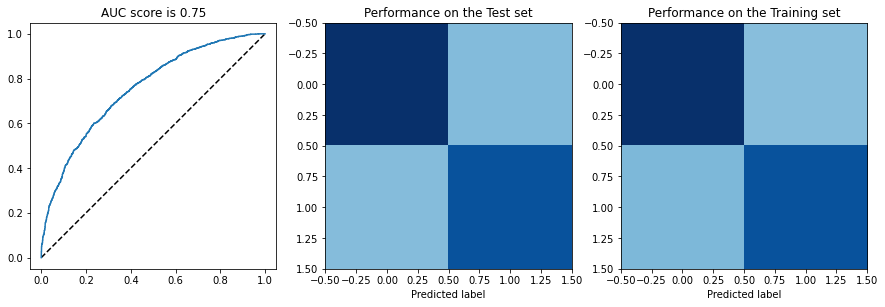

In [12]:
#선형회귀
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42) #random_state은 random 함수의 seed 값을 고정시키기 때문에 여러번 수행하더라도 같은 레코드를 추출한다. random_state를 어떤 값으로 해도 상관없다. 이는 random값을 고정하는 역할만 수행한다.

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

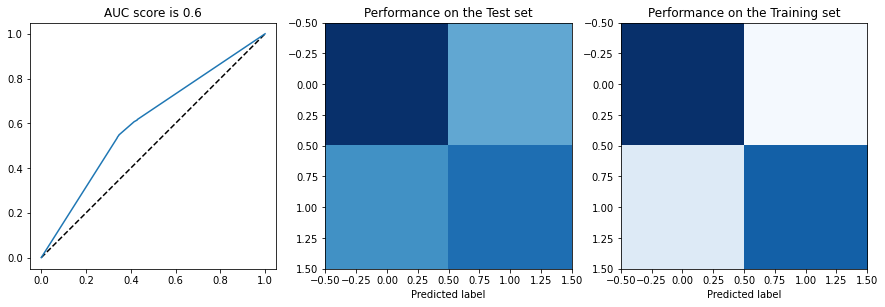

In [14]:
#의사결정트리
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

detree = tree.DecisionTreeClassifier()
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('decision_tree_regressor', detree)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

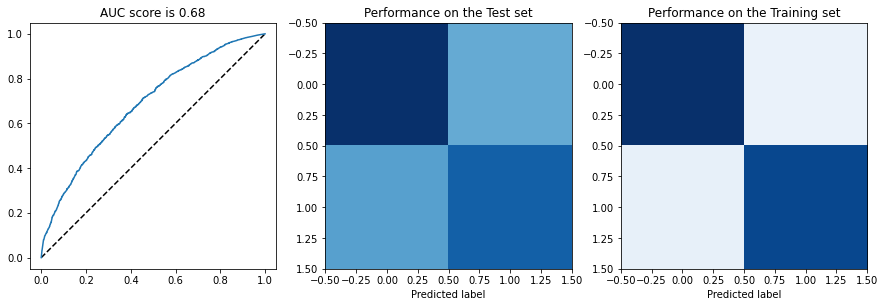

In [10]:
#랜덤포레스트
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

ranfo = ensemble.RandomForestClassifier()
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('decision_tree_regressor', ranfo)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

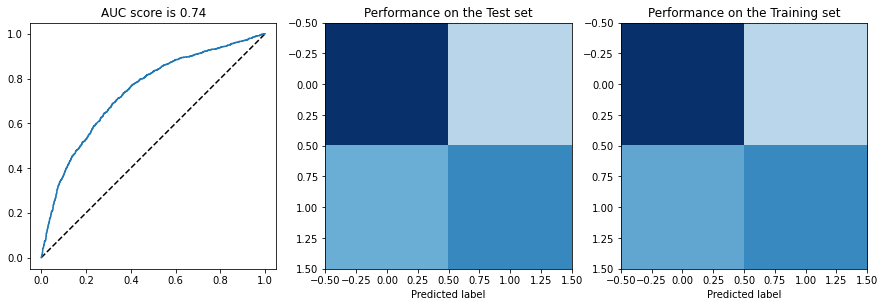

In [11]:
#SVM
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

svc = svm.SVC(probability=True)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('decision_tree_regressor', svc)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:51:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


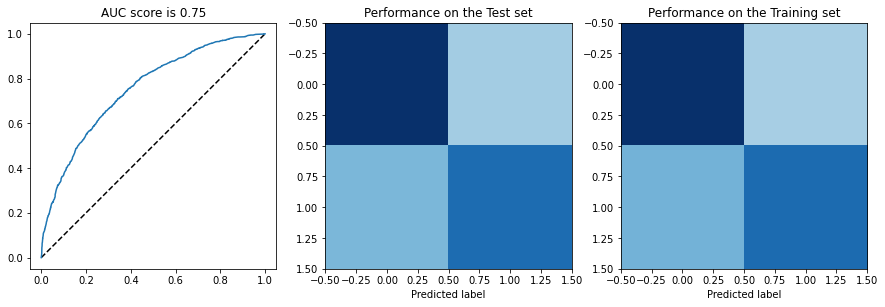

In [13]:
#XGBoostClassifier사용
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
X, y = matches.loc[:,['average_rank', 'rank_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('decision_tree_regressor', xg_reg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

Stakes distribution in the wrong predictions
True     0.56827
False    0.43173
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.632064
False    0.367936
Name: is_stake, dtype: float64


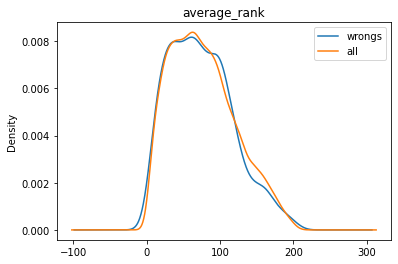

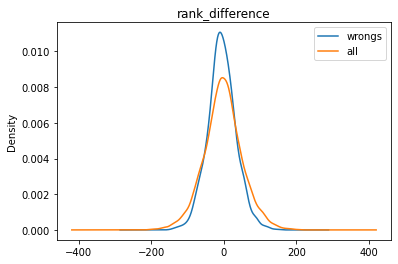

In [6]:
features = ['average_rank', 'rank_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

Simulation

In [7]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
olympic_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(olympic.index.unique())]
olympic_rankings = olympic_rankings.set_index(['country_full'])

In [8]:
from itertools import combinations

opponents = ['First match against', 'Second match against', 'Third match against']

olympic['points'] = 0
olympic['total_prob'] = 0

for group in set(olympic['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(olympic.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = olympic_rankings.loc[home, 'rank']
        # home_points = olympic_rankings.loc[home, 'weighted_points']
        opp_rank = olympic_rankings.loc[away, 'rank']
        # opp_points =olympicp_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        # row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        olympic.loc[home, 'total_prob'] += home_win_prob
        olympic.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            olympic.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            olympic.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            olympic.loc[home, 'points'] += 1
            olympic.loc[away, 'points'] += 1

___Starting group B:___
Korea Republic vs. Honduras: Draw
Korea Republic vs. New Zealand: Korea Republic wins with 0.79
Korea Republic vs. Romania: Korea Republic wins with 0.78
Honduras vs. New Zealand: Draw
Honduras vs. Romania: Romania wins with 0.73
New Zealand vs. Romania: Romania wins with 0.79
___Starting group C:___
Spain vs. Australia: Spain wins with 0.91
Spain vs. Egypt: Spain wins with 0.68
Spain vs. Argentina: Spain wins with 0.83
Australia vs. Egypt: Egypt wins with 0.70
Australia vs. Argentina: Argentina wins with 0.88
Egypt vs. Argentina: Argentina wins with 1.00
___Starting group A:___
Mexico vs. France: France wins with 0.85
Mexico vs. South Africa: Mexico wins with 0.95
Mexico vs. Japan: Mexico wins with 0.91
France vs. South Africa: South Africa wins with 0.64
France vs. Japan: France wins with 0.94
South Africa vs. Japan: Japan wins with 0.71
___Starting group D:___
Ivory Coast vs. Brazil: Brazil wins with 0.83
Ivory Coast vs. Germany: Germany wins with 0.96
Ivory 

In [9]:
pairing = [0,3,4,7,2,5,1,6]

olympic = olympic.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_olympic = olympic.groupby('Group').nth([0, 1]) # select the top 2
next_round_olympic = next_round_olympic.reset_index()
next_round_olympic = next_round_olympic.loc[pairing]
next_round_olympic = next_round_olympic.set_index('Team')


finals = ['round_of_8', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_olympic) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_olympic.index[i*2]
        away = next_round_olympic.index[i*2+1]
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = olympic_rankings.loc[home, 'rank']
        #home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = olympic_rankings.loc[away, 'rank']
        #opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        #row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(olympic_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        olympic_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_olympic = next_round_olympic.loc[winners]
    print("\n")

___Starting of the round_of_8___
France vs. Romania: France wins with probability 1.00
Spain vs. Brazil: Brazil wins with probability 0.85
Korea Republic vs. Argentina: Argentina wins with probability 0.61
Mexico vs. Germany: Mexico wins with probability 0.68


___Starting of the semifinal___
France vs. Brazil: France wins with probability 0.55
Argentina vs. Mexico: Mexico wins with probability 0.54


___Starting of the final___
France vs. Mexico: France wins with probability 0.72




visualizaiton

In [ ]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2,2)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(15, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 8', 'blue'), (210, 'Semifinal', 'red'), (130, 'Final', 'yellow'))
[plt.text(p, centre+30, t, 
          fontsize=20, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()